In [4]:
import sys, subprocess

print("Python:", sys.version)
py_ok = sys.version.startswith("3.8")
print("✅ Python 3.8 OK" if py_ok else "❌ Not Python 3.8 — please switch kernel to a 3.8 env")

def ensure(pkg, ver=None):
    try:
        __import__(pkg.split("==")[0])
        print(f"✓ {pkg} already available")
    except Exception:
        print(f"→ installing {pkg} …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Minimal deps that are safe for PyCaret 2.3.x
ensure("numpy==1.23.5")
ensure("pandas==1.5.3")
# Optional (PyCaret path). If import later fails, we’ll auto-fallback to mlxtend.
try:
    import pycaret
    print("✓ pycaret", pycaret.__version__)
except Exception:
    print("ℹ️ PyCaret not found now; we’ll try the mlxtend fallback if needed.")

Python: 3.8.18 (default, Nov  2 2025, 20:19:33) 
[Clang 17.0.0 (clang-1700.0.13.5)]
✅ Python 3.8 OK
✓ numpy==1.23.5 already available
✓ pandas==1.5.3 already available
ℹ️ PyCaret not found now; we’ll try the mlxtend fallback if needed.


In [6]:
# STEP 1 — Kaggle download: heeraldedhia/groceries-dataset  → ./data/groceries_assoc

import os, sys, json, zipfile, pathlib, subprocess

KAGGLE_DATASET = "heeraldedhia/groceries-dataset"
DATA_ROOT      = os.path.abspath("./data")
DATASET_DIR    = os.path.join(DATA_ROOT, "groceries_assoc")
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)

# 1) Ensure kaggle CLI in this kernel
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "kaggle"], check=True)

# 2) Try to load Kaggle creds from env or ~/.kaggle/kaggle.json
home = str(pathlib.Path.home())
kaggle_dir  = os.path.join(home, ".kaggle")
kaggle_json = os.path.join(kaggle_dir, "kaggle.json")
os.makedirs(kaggle_dir, exist_ok=True)

KAGGLE_USERNAME = os.environ.get("KAGGLE_USERNAME", "iamvijayshankar")
KAGGLE_KEY      = os.environ.get("KAGGLE_KEY", "5432ac578dbd76cbbfa10a1935b6e4aa")

if KAGGLE_USERNAME and KAGGLE_KEY:
    with open(kaggle_json, "w") as f:
        json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
    try:
        os.chmod(kaggle_json, 0o600)
    except Exception:
        pass
elif not os.path.isfile(kaggle_json):
    raise FileNotFoundError(
        "Kaggle credentials not found.\n"
        "Either set env vars KAGGLE_USERNAME/KAGGLE_KEY in this kernel, "
        "or place kaggle.json at ~/.kaggle/kaggle.json (from Kaggle → Account → Create New API Token)."
    )

# 3) Download the dataset zip into DATA_ROOT
print("Downloading from Kaggle…")
subprocess.run([
    "kaggle", "datasets", "download",
    "-d", KAGGLE_DATASET,
    "-p", DATA_ROOT,
    "--force"
], check=True)

# 4) Unzip all zips found in DATA_ROOT into DATASET_DIR
for fname in os.listdir(DATA_ROOT):
    if fname.lower().endswith(".zip"):
        zpath = os.path.join(DATA_ROOT, fname)
        print("Unzipping:", zpath)
        with zipfile.ZipFile(zpath, "r") as zf:
            zf.extractall(DATASET_DIR)
        os.remove(zpath)

print("\nContents of dataset directory:")
for f in os.listdir(DATASET_DIR):
    print(" -", f)

Dataset URL: https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset
License(s): GPL-2.0

Unzipping: /Users/spartan/assigment/pycaret_6/data/groceries-dataset.zip

Contents of dataset directory:
 - Groceries_dataset.csv


100%|██████████| 257k/257k [00:00<00:00, 380MB/s]


In [7]:
import os, glob
import pandas as pd

DATA_ROOT   = os.path.abspath("./data")
DATASET_DIR = os.path.join(DATA_ROOT, "groceries_assoc")

# 2.1 Find the groceries CSV robustly (commonly named "Groceries_dataset.csv")
candidates = glob.glob(os.path.join(DATASET_DIR, "*.csv"))
if not candidates:
    raise FileNotFoundError(f"No CSV found in {DATASET_DIR}. Contents: {os.listdir(DATASET_DIR) if os.path.exists(DATASET_DIR) else 'missing dir'}")

# Prefer a filename containing 'Grocer' if present; otherwise first CSV
CSV_PATH = next((c for c in candidates if "Grocer" in os.path.basename(c)), candidates[0])
print("Using file:", os.path.basename(CSV_PATH))

# 2.2 Read + quick checks
df = pd.read_csv(CSV_PATH)
print("Raw shape:", df.shape)
display(df.head())

# 2.3 Normalize expected column names to a common schema
# Many public versions use: Member_number, Date, itemDescription
col_map = {}
for c in df.columns:
    lc = c.strip().lower()
    if lc.startswith("member"): col_map[c] = "Member_number"
    elif lc.startswith("date"): col_map[c] = "Date"
    elif "item" in lc and "desc" in lc: col_map[c] = "itemDescription"
df = df.rename(columns=col_map)

required = {"Member_number", "Date", "itemDescription"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}. Found: {df.columns.tolist()}")

# 2.4 Clean item text and build transaction id (tid = member + date)
df["itemDescription"] = df["itemDescription"].astype(str).str.strip()
df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.date
df["tid"] = df["Member_number"].astype(str) + "_" + df["Date"].astype(str)

# 2.5 Drop rows missing essentials
before = len(df)
df = df.dropna(subset=["tid", "itemDescription"]).reset_index(drop=True)
print(f"Cleaned shape: {df.shape} (dropped {before - len(df)} rows)")

# 2.6 Quick basket & item stats
n_tx = df["tid"].nunique()
n_items = df["itemDescription"].nunique()
print(f"\nTransactions (baskets): {n_tx:,}")
print(f"Unique items: {n_items:,}")

print("\nTop 10 items:")
display(df["itemDescription"].value_counts().head(10))

# Keep for next step:
# df must have: ['Member_number', 'Date', 'itemDescription', 'tid']

Using file: Groceries_dataset.csv
Raw shape: (38765, 3)


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


Cleaned shape: (38765, 4) (dropped 0 rows)

Transactions (baskets): 14,963
Unique items: 167

Top 10 items:


/var/folders/2c/4_znv9nx6sqd35cxryy2ks540000gq/T/ipykernel_58354/55717769.py:38: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.date


whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: itemDescription, dtype: int64

In [10]:
import sys, subprocess
import pandas as pd

# 3.0 Ensure mlxtend is available (quiet install if needed)
try:
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import apriori, association_rules
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "mlxtend==0.22.0"])
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import apriori, association_rules

# We expect df from Step 2 with columns: ['tid','itemDescription']
assert {'tid','itemDescription'}.issubset(df.columns), "Run STEP 2 first to build df with 'tid' and 'itemDescription'."

# 3.1 Build list-of-lists transactions
baskets = (
    df[['tid','itemDescription']]
      .dropna()
      .groupby('tid')['itemDescription']
      .apply(list)
      .tolist()
)

# 3.2 One-hot encode transactions
te = TransactionEncoder()
oht = pd.DataFrame(te.fit_transform(baskets), columns=te.columns_)

# 3.3 Frequent itemsets via Apriori
# Tip: If you get too few/many itemsets, adjust min_support (e.g., 0.02 ↔ 0.005)
freq = apriori(oht, min_support=0.01, use_colnames=True)
freq = freq.sort_values('support', ascending=False).reset_index(drop=True)
print(f"Frequent itemsets found: {len(freq)}")
display(freq.head(10))

# 3.4 Association rules (confidence as the main filter; you can change to 'lift', 'leverage', etc.)
rules = association_rules(freq, metric='confidence', min_threshold=0.25)
rules = rules.sort_values(['confidence','lift'], ascending=[False, False]).reset_index(drop=True)
print(f"Rules found: {len(rules)}")
display(rules.head(10))

# 3.5 Save artifacts
import os
os.makedirs("./artifacts", exist_ok=True)
freq_path  = "./artifacts/groceries_frequent_itemsets.csv"
rules_path = "./artifacts/groceries_rules.csv"
freq.to_csv(freq_path, index=False)
rules.to_csv(rules_path, index=False)
print(f"✅ Saved frequent itemsets to: {freq_path}")
print(f"✅ Saved rules to: {rules_path}")


Frequent itemsets found: 69


,support,itemsets
0,0.157923,(whole milk)
1,0.122101,(other vegetables)
2,0.110005,(rolls/buns)
3,0.097106,(soda)
4,0.085879,(yogurt)
5,0.069572,(root vegetables)
6,0.067767,(tropical fruit)
7,0.060683,(bottled water)
8,0.060349,(sausage)
9,0.053131,(citrus fruit)


Rules found: 0


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


✅ Saved frequent itemsets to: ./artifacts/groceries_frequent_itemsets.csv
✅ Saved rules to: ./artifacts/groceries_rules.csv


In [13]:
import sys, subprocess, os
import pandas as pd

# Ensure mlxtend is installed
try:
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "mlxtend==0.22.0"])
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

assert {'tid','itemDescription'}.issubset(df.columns), "Run Step 2 to create df with 'tid' and 'itemDescription'."

# Build one-hot table (if not already built in Step 3)
if 'oht' not in globals():
    baskets = (
        df[['tid','itemDescription']]
          .dropna()
          .groupby('tid')['itemDescription']
          .apply(list)
          .tolist()
    )
    te = TransactionEncoder()
    oht = pd.DataFrame(te.fit_transform(baskets), columns=te.columns_)

def mine_rules(oht, method='apriori', min_support=0.01, min_conf=0.25, max_len=None):
    if method == 'apriori':
        freq = apriori(oht, min_support=min_support, use_colnames=True, max_len=max_len)
    else:
        freq = fpgrowth(oht, min_support=min_support, use_colnames=True, max_len=max_len)
    if freq.empty:
        return freq, pd.DataFrame()
    rules = association_rules(freq, metric='confidence', min_threshold=min_conf)
    if not rules.empty:
        rules = rules.sort_values(['confidence','lift','support'], ascending=[False, False, False]).reset_index(drop=True)
    return freq, rules

# Adaptive sweep
supports  = [0.02, 0.01, 0.005, 0.003, 0.002, 0.001]
confidences = [0.30, 0.25, 0.20, 0.15, 0.10]
found = False
chosen = dict(method=None, min_support=None, min_conf=None, n_rules=0)

for ms in supports:
    for mc in confidences:
        freq, rules = mine_rules(oht, method='apriori', min_support=ms, min_conf=mc)
        if len(rules) >= 25:  # good enough
            chosen.update(method='apriori', min_support=ms, min_conf=mc, n_rules=len(rules))
            found = True
            break
    if found:
        break

if not found:
    # try FP-Growth with relaxed settings
    for ms in supports:
        for mc in confidences[::-1]:  # go low confidence first for FP-growth
            freq, rules = mine_rules(oht, method='fpgrowth', min_support=ms, min_conf=mc)
            if len(rules) >= 25 or (len(rules) > 0 and ms <= 0.005):
                chosen.update(method='fpgrowth', min_support=ms, min_conf=mc, n_rules=len(rules))
                found = True
                break
        if found:
            break

# If still nothing, keep whatever we got (possibly zero) at the loosest setting
if not found:
    freq, rules = mine_rules(oht, method='fpgrowth', min_support=0.001, min_conf=0.10)
    chosen.update(method='fpgrowth', min_support=0.001, min_conf=0.10, n_rules=len(rules))

print("Mining summary →",
      f"method={chosen['method']}, min_support={chosen['min_support']}, min_conf={chosen['min_conf']}, rules={chosen['n_rules']}")

# Pretty columns for downstream steps
if not rules.empty:
    def itemset_to_str(s): return " + ".join(sorted(map(str, list(s))))
    rules = rules.copy()
    rules["antecedent_str"] = rules["antecedents"].apply(itemset_to_str)
    rules["consequent_str"] = rules["consequents"].apply(itemset_to_str)
    rules["rule_str"]       = rules["antecedent_str"] + " ⇒ " + rules["consequent_str"]

# Save artifacts
os.makedirs("./artifacts", exist_ok=True)
freq_path  = "./artifacts/groceries_frequent_itemsets_adaptive.csv"
rules_path = "./artifacts/groceries_rules_adaptive.csv"
freq.to_csv(freq_path, index=False)
rules.to_csv(rules_path, index=False)
print(f"✅ Saved itemsets: {freq_path}")
print(f"✅ Saved rules   : {rules_path}")

# Expose 'rules' for Step 5
print(rules.head(10) if not rules.empty else "No rules after adaptive mining; Step 5 will use co-occurrence fallback.")


Mining summary → method=apriori, min_support=0.003, min_conf=0.1, rules=39
✅ Saved itemsets: ./artifacts/groceries_frequent_itemsets_adaptive.csv
✅ Saved rules   : ./artifacts/groceries_rules_adaptive.csv
           antecedents         consequents  antecedent support  \
0       (bottled beer)        (whole milk)            0.045312   
1            (sausage)        (whole milk)            0.060349   
2         (newspapers)        (whole milk)            0.038896   
3      (domestic eggs)        (whole milk)            0.037091   
4     (hamburger meat)        (whole milk)            0.021854   
5        (frankfurter)        (whole milk)            0.037760   
6               (beef)        (whole milk)            0.033950   
7        (frankfurter)  (other vegetables)            0.037760   
8  (frozen vegetables)        (whole milk)            0.028002   
9               (pork)        (whole milk)            0.037091   

   consequent support   support  confidence      lift  leverage  con

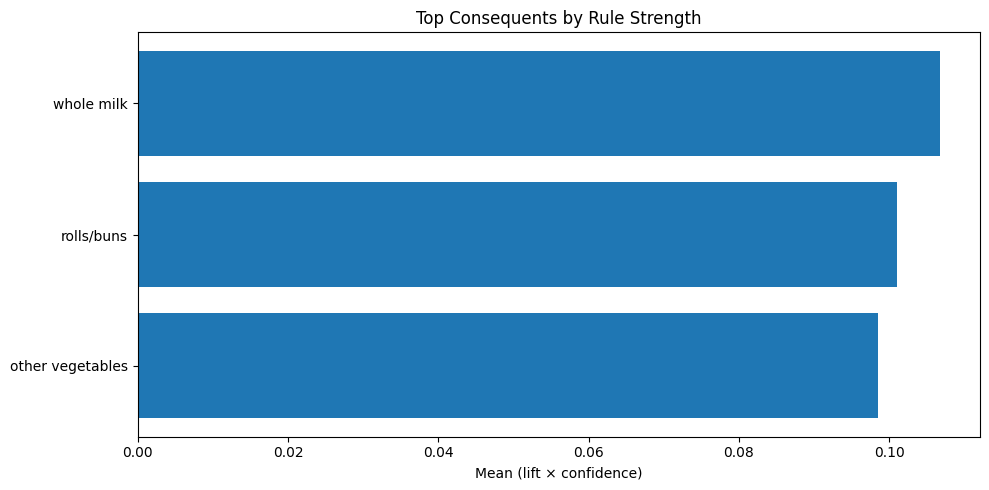

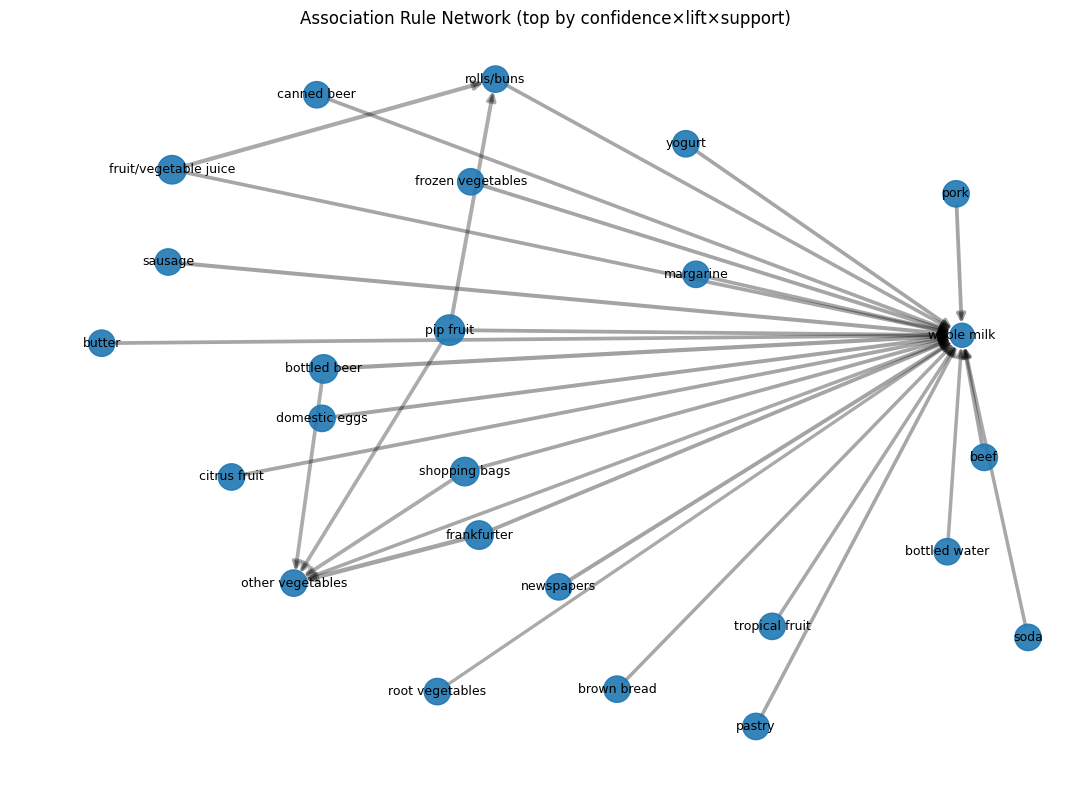

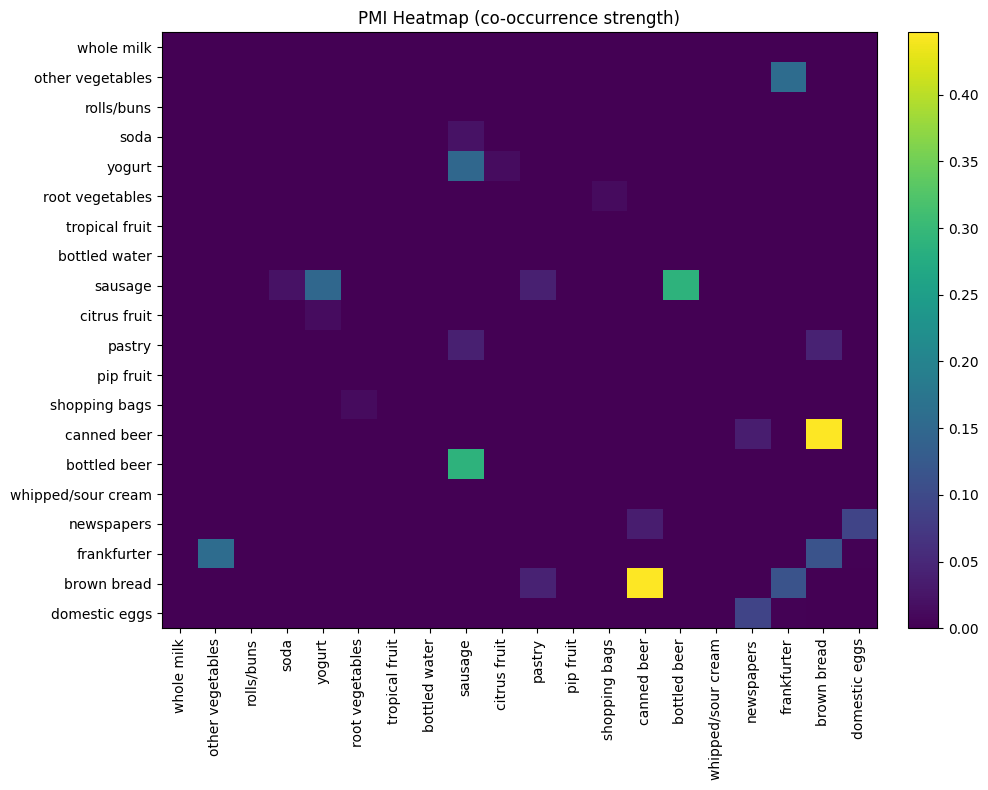

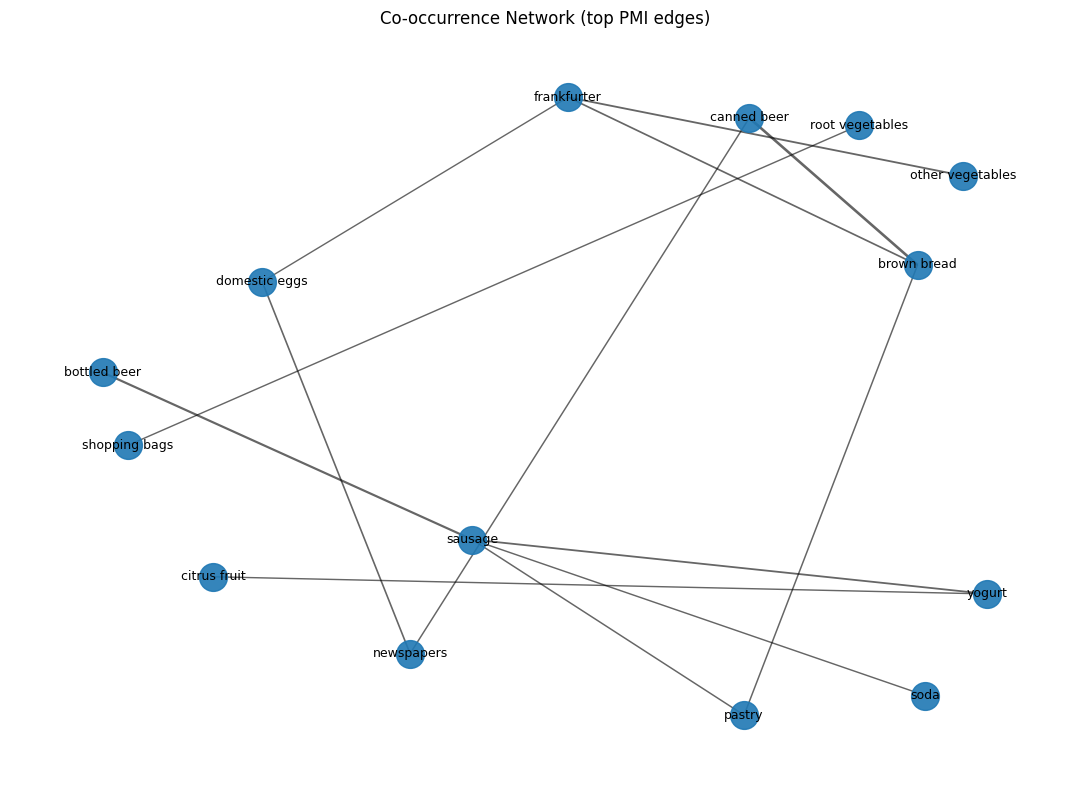

✅ STEP 5 (ALT) complete — visuals generated (rules or co-occurrence).


In [14]:
import sys, subprocess, os, math
import pandas as pd
import numpy as np

# Ensure plotting + network deps
def ensure(pkg):
    try:
        __import__(pkg)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

ensure("matplotlib")
ensure("networkx")

import matplotlib.pyplot as plt
import networkx as nx

# Load rules if not in memory
if 'rules' not in globals():
    rules_csv = "./artifacts/groceries_rules_adaptive.csv"
    if os.path.isfile(rules_csv):
        rules = pd.read_csv(rules_csv)
    else:
        rules = pd.DataFrame()

# Helper to split 'a + b' strings
def split_items(s):
    if pd.isna(s) or not isinstance(s, str) or not s.strip():
        return []
    return [x.strip() for x in s.split("+") if x.strip()]

has_rules = (not rules.empty) and all(c in rules.columns for c in ["rule_str","antecedent_str","consequent_str","support","confidence","lift"])

if has_rules:
    # ---------------------------
    # A) Bar chart: top consequents by mean(lift * confidence)
    # ---------------------------
    g = (rules
         .groupby("consequent_str", as_index=False)
         .agg(n_rules=("rule_str","count"), mean_conf=("confidence","mean"), mean_lift=("lift","mean")))
    g["score"] = g["mean_conf"] * g["mean_lift"]
    g = g.sort_values("score", ascending=False)
    top = g.head(min(15, len(g)))

    plt.figure(figsize=(10,5))
    plt.barh(top["consequent_str"][::-1], top["score"][::-1])
    plt.xlabel("Mean (lift × confidence)")
    plt.title("Top Consequents by Rule Strength")
    plt.tight_layout(); plt.show()

    # ---------------------------
    # B) Network graph: top rules by rank score
    # ---------------------------
    r2 = rules.copy()
    r2["rank_score"] = r2["confidence"] * r2["lift"] * r2["support"]
    rt = r2.sort_values("rank_score", ascending=False).head(30)

    G = nx.DiGraph()
    for _, row in rt.iterrows():
        ants = split_items(row["antecedent_str"])
        cons = split_items(row["consequent_str"])
        for a in ants:
            for c in cons:
                G.add_node(a); G.add_node(c)
                G.add_edge(a, c, weight=float(row.get("lift",1.0)), conf=float(row.get("confidence",0.0)), sup=float(row.get("support",0.0)))

    plt.figure(figsize=(11,8))
    pos = nx.spring_layout(G, k=0.6, seed=42)
    deg = dict(G.out_degree())
    node_sizes = [300 + 60*deg.get(n,0) for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=9)

    edges = G.edges(data=True)
    for (u,v,d) in edges:
        w = 1.0 + 2.0*min(3.0, d.get("weight",1.0))
        a = 0.25 + 0.75*d.get("conf",0.0)
        nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], width=w, alpha=a, arrows=True, arrowsize=12)

    plt.title("Association Rule Network (top by confidence×lift×support)")
    plt.axis("off"); plt.tight_layout(); plt.show()

else:
    print("No rules available — using co-occurrence/PMI fallback.")

# ---------------------------
# Co-occurrence/PMI fallback (also useful even if rules exist)
# ---------------------------
# Build baskets list if needed
if 'baskets' not in globals():
    baskets = (
        df[['tid','itemDescription']]
          .dropna()
          .groupby('tid')['itemDescription']
          .apply(list)
          .tolist()
    )

# Count singles and pairs
from collections import Counter
single = Counter()
pair = Counter()
for items in baskets:
    uniq = sorted(set(items))
    single.update(uniq)
    for i in range(len(uniq)):
        for j in range(i+1, len(uniq)):
            pair[(uniq[i], uniq[j])] += 1

n_tx = len(baskets)
# Compute PMI for pairs: log( P(i,j) / (P(i)*P(j)) )
def pmi(i, j):
    cij = pair.get((min(i,j), max(i,j)), 0)
    if cij == 0: return 0.0
    pi = single[i] / n_tx
    pj = single[j] / n_tx
    pij = cij / n_tx
    return np.log2(pij / (pi * pj)) if pi>0 and pj>0 else 0.0

# Choose top items by frequency
top_items = [it for it, _ in single.most_common(20)]

# Heatmap of PMI
mat = np.zeros((len(top_items), len(top_items)))
for a_idx, a in enumerate(top_items):
    for c_idx, c in enumerate(top_items):
        if a == c: continue
        mat[a_idx, c_idx] = max(0.0, pmi(a, c))  # keep non-negative for visual clarity

plt.figure(figsize=(10,8))
im = plt.imshow(mat, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(top_items)), top_items, rotation=90)
plt.yticks(range(len(top_items)), top_items)
plt.title("PMI Heatmap (co-occurrence strength)")
plt.tight_layout(); plt.show()

# Co-occurrence network (top PMI edges)
edges = []
for i, a in enumerate(top_items):
    for j, c in enumerate(top_items):
        if j <= i: continue
        val = mat[i, j]
        if val > 0:
            edges.append((a, c, val))
edges = sorted(edges, key=lambda x: x[2], reverse=True)[:40]

G2 = nx.Graph()
for a, c, w in edges:
    G2.add_node(a); G2.add_node(c)
    G2.add_edge(a, c, weight=w)

plt.figure(figsize=(11,8))
pos = nx.spring_layout(G2, k=0.7, seed=42)
nx.draw_networkx_nodes(G2, pos, node_size=400, alpha=0.9)
nx.draw_networkx_labels(G2, pos, font_size=9)
ew = [1 + 2*min(4, d["weight"]) for (_,_,d) in G2.edges(data=True)]
nx.draw_networkx_edges(G2, pos, width=ew, alpha=0.6)
plt.title("Co-occurrence Network (top PMI edges)")
plt.axis("off"); plt.tight_layout(); plt.show()

print("✅ STEP 5 (ALT) complete — visuals generated (rules or co-occurrence).")
